In [1]:
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Qubit, Instruction, Operation, CircuitInstruction
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

from circuit_knitting.cutting import partition_problem, generate_cutting_experiments, cut_gates
from circuit_knitting.cutting.instructions import Move

from cutter_search_manual import *
from resource_analysis import PhysicalParameters


def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 15
             Gate count: 21
    Nonlocal gate count: 8
         Gate breakdown: RZ: 10, CX: 8, RY: 2, RX: 1


SparsePauliOp(['IZZ', 'ZZI', 'IIZ', 'IZI', 'ZII', 'IIX', 'IXI', 'XII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])


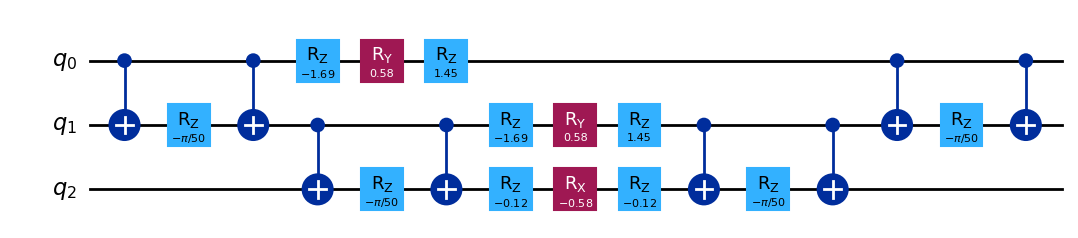

In [2]:
second_order_formula = SuzukiTrotter()

L = 3
H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
final_time = np.pi
num_timesteps = 10
dt = final_time / num_timesteps
initial_state = Statevector.from_label("000")

trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
for i in range(1):
    circuit.append(trotter_step_second_order, range(H.num_qubits))
# circuit = circuit.decompose(reps=1)
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
circuit = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)
print(H)

circuit.draw("mpl")

In [3]:
import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(7, 6, max_operands=2, seed=1242)
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])


from automation import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)
action = find_cuts(circuit, optimization_settings, device_constraints)
# cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
# print(
#     f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
#     f'overhead of {metadata["sampling_overhead"]}.'
# )
# for cut in metadata["cuts"]:
#     print(f"{cut[0]} at circuit instruction index {cut[1]}")
# cut_circuit.draw("mpl", scale=0.8, fold=-1)

In [19]:
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
qc_to_cco_circuit(circuit)[0].gamma

3.0

In [17]:
action[1].gate_spec

GateSpec(instruction_id=27, gate=CircuitElement(name='crz', params=[2.2818175923666106], qubits=[6, 3], gamma=2.8180252582601235), cut_constraints=None)

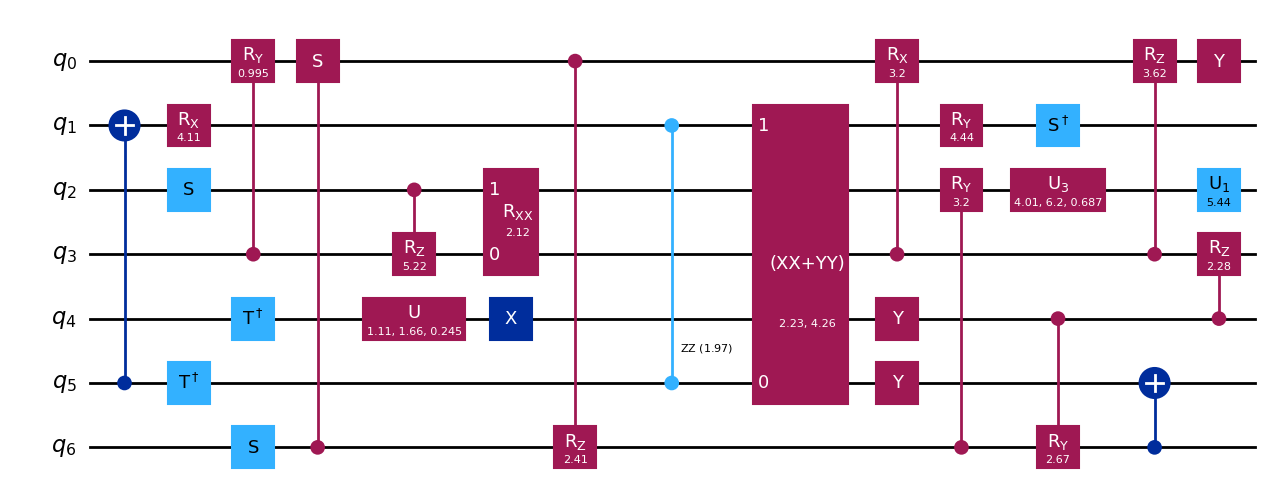

In [14]:
circuit.draw("mpl")

In [6]:
# for ins in circuit.data:
#     print(ins)

In [7]:
# circuit.data.insert(3,(Instruction(name='move', num_qubits=2, num_clbits=0, params=[]),[Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1)],[]))
# circuit.data.insert(7,(Instruction(name='move', num_qubits=2, num_clbits=0, params=[]),[Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 0)],[]))

In [8]:
# # Find the indices of the distant gates
# cut_indices = [
#     i
#     for i, instruction in enumerate(circuit.data)
#     if {circuit.find_bit(q)[0] for q in instruction.qubits} == {1, 2}
# ]

# # Decompose distant CNOTs into TwoQubitQPDGate instances
# qpd_circuit, bases_cnot = cut_gates(circuit, cut_indices)

# qpd_circuit.draw("mpl", scale=0.8)

In [9]:
# partitioned_problem = partition_problem(
#     circuit=circuit, partition_labels="ABC"
# )
# subcircuits = partitioned_problem.subcircuit
# bases = partitioned_problem.bases

In [10]:
# subcircuits["A"].draw("mpl", scale=0.8)

In [11]:
# subcircuits["B"].draw("mpl", scale=0.8)

In [12]:
# print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")